Saaksshi Jilhewar - sjilhewa \
Gauri Dalwankar - gdalwank

In [26]:
#importing libraries

import findspark
import pyspark
import pyspark.sql.functions as F
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [33]:
#creating spark session

findspark.init()
findspark.find()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

In [34]:
#accessing dataset

train = spark.read.csv( ("gs://dataproc-staging-us-west3-992614686258-onm7tiya/train70_augmented.csv"),header=True, inferSchema= True)
test = spark.read.csv( ("gs://dataproc-staging-us-west3-992614686258-onm7tiya/test30_augmented.csv"),header=True, inferSchema= True)

In [35]:
#ingesting only a fraction of dataset because system kept showing error(image added below) or no response from spark

x = train.head(140000)
y = test.head(60000)

DF_train = spark.createDataFrame(x)
DF_test = spark.createDataFrame(y)
DF = DF_train.union(DF_test)

DF=DF.toDF(*(c.replace('.', '_') for c in DF.columns))

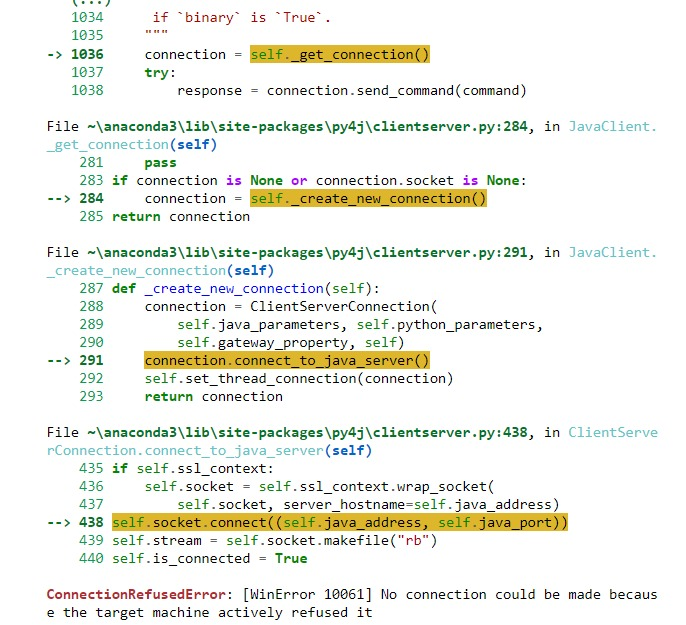

In [5]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="17032007"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt.MQTT"

DF.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [6]:
spark = SparkSession.builder.appName("Basics").getOrCreate()
sc=spark.sparkContext
sqlContext = SQLContext(sc)

DF= sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

DF.show(1, vertical=True)

C:\Users\gauri\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 4.71E-4    
 tcp_len                    | 2          
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 1.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0x00000002 
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000010 
 mqtt_kalive                | 65535.0    
 mqtt_len                   | 30.0       
 mqtt_msg                   | 0.0        
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 1.0        
 mqtt_proto_len             | 4.0 

In [36]:
#adition of field column, 0 is train and 1 test

DF = DF.withColumn( "id", monotonically_increasing_id() )
data=DF.withColumn("Field",when(DF.id<="140000",0).otherwise(1))
DF=data.drop(data.id)
DF.show(truncate=True, vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 1.000039   
 tcp_len                    | 13         
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000030 
 mqtt_kalive                | 0.0        
 mqtt_len                   | 11.0       
 mqtt_msg                   | 32         
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 3.0        
 mqtt_proto_len             | 0.0 

22/11/28 05:41:47 WARN org.apache.spark.scheduler.TaskSetManager: Stage 33 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


In [37]:
DF.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: long (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- m

In [38]:
# chceking dataset for null/nan values

DF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in DF.columns]).show(1, vertical=True)


22/11/28 05:42:10 WARN org.apache.spark.scheduler.TaskSetManager: Stage 34 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


-RECORD 0-------------------------
 tcp_flags                  | 0   
 tcp_time_delta             | 0   
 tcp_len                    | 0   
 mqtt_conack_flags          | 0   
 mqtt_conack_flags_reserved | 0   
 mqtt_conack_flags_sp       | 0   
 mqtt_conack_val            | 0   
 mqtt_conflag_cleansess     | 0   
 mqtt_conflag_passwd        | 0   
 mqtt_conflag_qos           | 0   
 mqtt_conflag_reserved      | 0   
 mqtt_conflag_retain        | 0   
 mqtt_conflag_uname         | 0   
 mqtt_conflag_willflag      | 0   
 mqtt_conflags              | 0   
 mqtt_dupflag               | 0   
 mqtt_hdrflags              | 0   
 mqtt_kalive                | 0   
 mqtt_len                   | 0   
 mqtt_msg                   | 0   
 mqtt_msgid                 | 0   
 mqtt_msgtype               | 0   
 mqtt_proto_len             | 0   
 mqtt_protoname             | 0   
 mqtt_qos                   | 0   
 mqtt_retain                | 0   
 mqtt_sub_qos               | 0   
 mqtt_suback_qos    

from above we can see that, there are no nan/null values, so we dont need to impute the dataset.

In [39]:
#collecting all numerical features for outliers finding

numeric_features = [feature[0] for feature in DF.dtypes if feature[1] in ('int','double')]
DF[numeric_features]


DataFrame[tcp_time_delta: double, mqtt_conack_flags_reserved: double, mqtt_conack_flags_sp: double, mqtt_conack_val: double, mqtt_conflag_cleansess: double, mqtt_conflag_passwd: double, mqtt_conflag_qos: double, mqtt_conflag_reserved: double, mqtt_conflag_retain: double, mqtt_conflag_uname: double, mqtt_conflag_willflag: double, mqtt_dupflag: double, mqtt_kalive: double, mqtt_len: double, mqtt_msgid: double, mqtt_msgtype: double, mqtt_proto_len: double, mqtt_qos: double, mqtt_retain: double, mqtt_sub_qos: double, mqtt_suback_qos: double, mqtt_ver: double, mqtt_willmsg: double, mqtt_willmsg_len: double, mqtt_willtopic: double, mqtt_willtopic_len: double, Field: int]

22/11/28 05:42:18 WARN org.apache.spark.scheduler.TaskSetManager: Stage 37 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


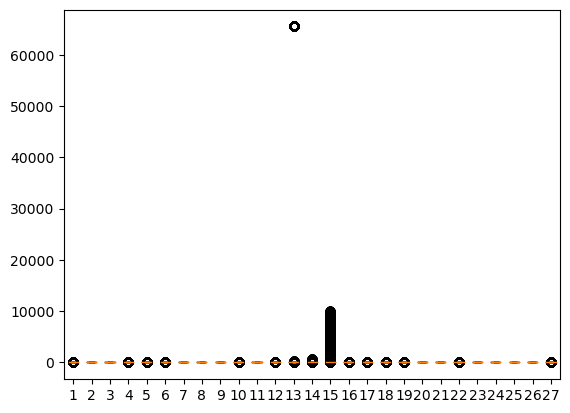

In [40]:
#Extract data and convert them into Pandas for visualization
#plotting box-plots for checking of outliers

converted_data = DF[numeric_features].toPandas()
figure = plt.boxplot(converted_data)

22/11/28 05:42:26 WARN org.apache.spark.scheduler.TaskSetManager: Stage 38 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


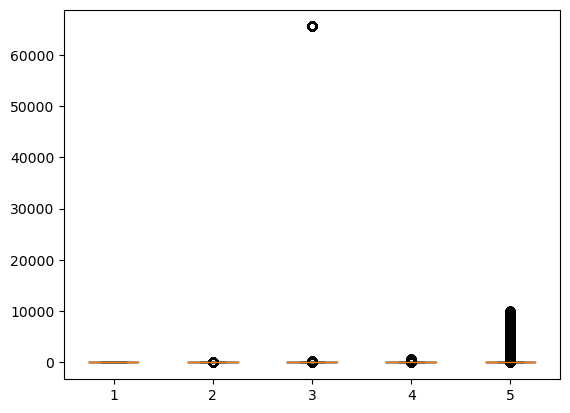

In [41]:
#zooming-in on box plots

spotted_data = DF[numeric_features[10:15]].toPandas()
figure_subset = plt.boxplot(spotted_data)

In [42]:
#finding outliers

from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [43]:
df_with_outlier_handling = find_outliers(DF)
df_with_outlier_handling.show(1, vertical=True)

22/11/28 05:42:33 WARN org.apache.spark.scheduler.TaskSetManager: Stage 39 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.
22/11/28 05:42:34 WARN org.apache.spark.scheduler.TaskSetManager: Stage 41 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 1.000039   
 tcp_len                    | 13         
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000030 
 mqtt_kalive                | 0.0        
 mqtt_len                   | 11.0       
 mqtt_msg                   | 32         
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 3.0        
 mqtt_proto_len             | 0.0 

22/11/28 05:42:35 WARN org.apache.spark.scheduler.TaskSetManager: Stage 43 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


In [44]:
DF=DF.drop('Field')

In [45]:
DF.printSchema()


root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: long (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- m

these numeric features are our continuous columns, nominal columns will be the ones which have string data type.

In [46]:
col_names = ['tcp_flags',
 'tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_conflags',
 'mqtt_dupflag',
 'mqtt_hdrflags',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msg',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len',
 'target']

nominal_cols = ['tcp_flags',
 'mqtt_conack_flags',
 'mqtt_conflags',
 'mqtt_hdrflags',
 'mqtt_msg',
 'mqtt_protoname']

continuous_cols = ['tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_dupflag',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len']

In our dataset we need to drop columns which are highly correlated, to do so we need to plot correlation matrix and chcek for high correlation. In this case we have considered correlation of above and equal to 0.90 are highly correlated columns. 

22/11/28 05:43:46 WARN org.apache.spark.scheduler.TaskSetManager: Stage 44 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


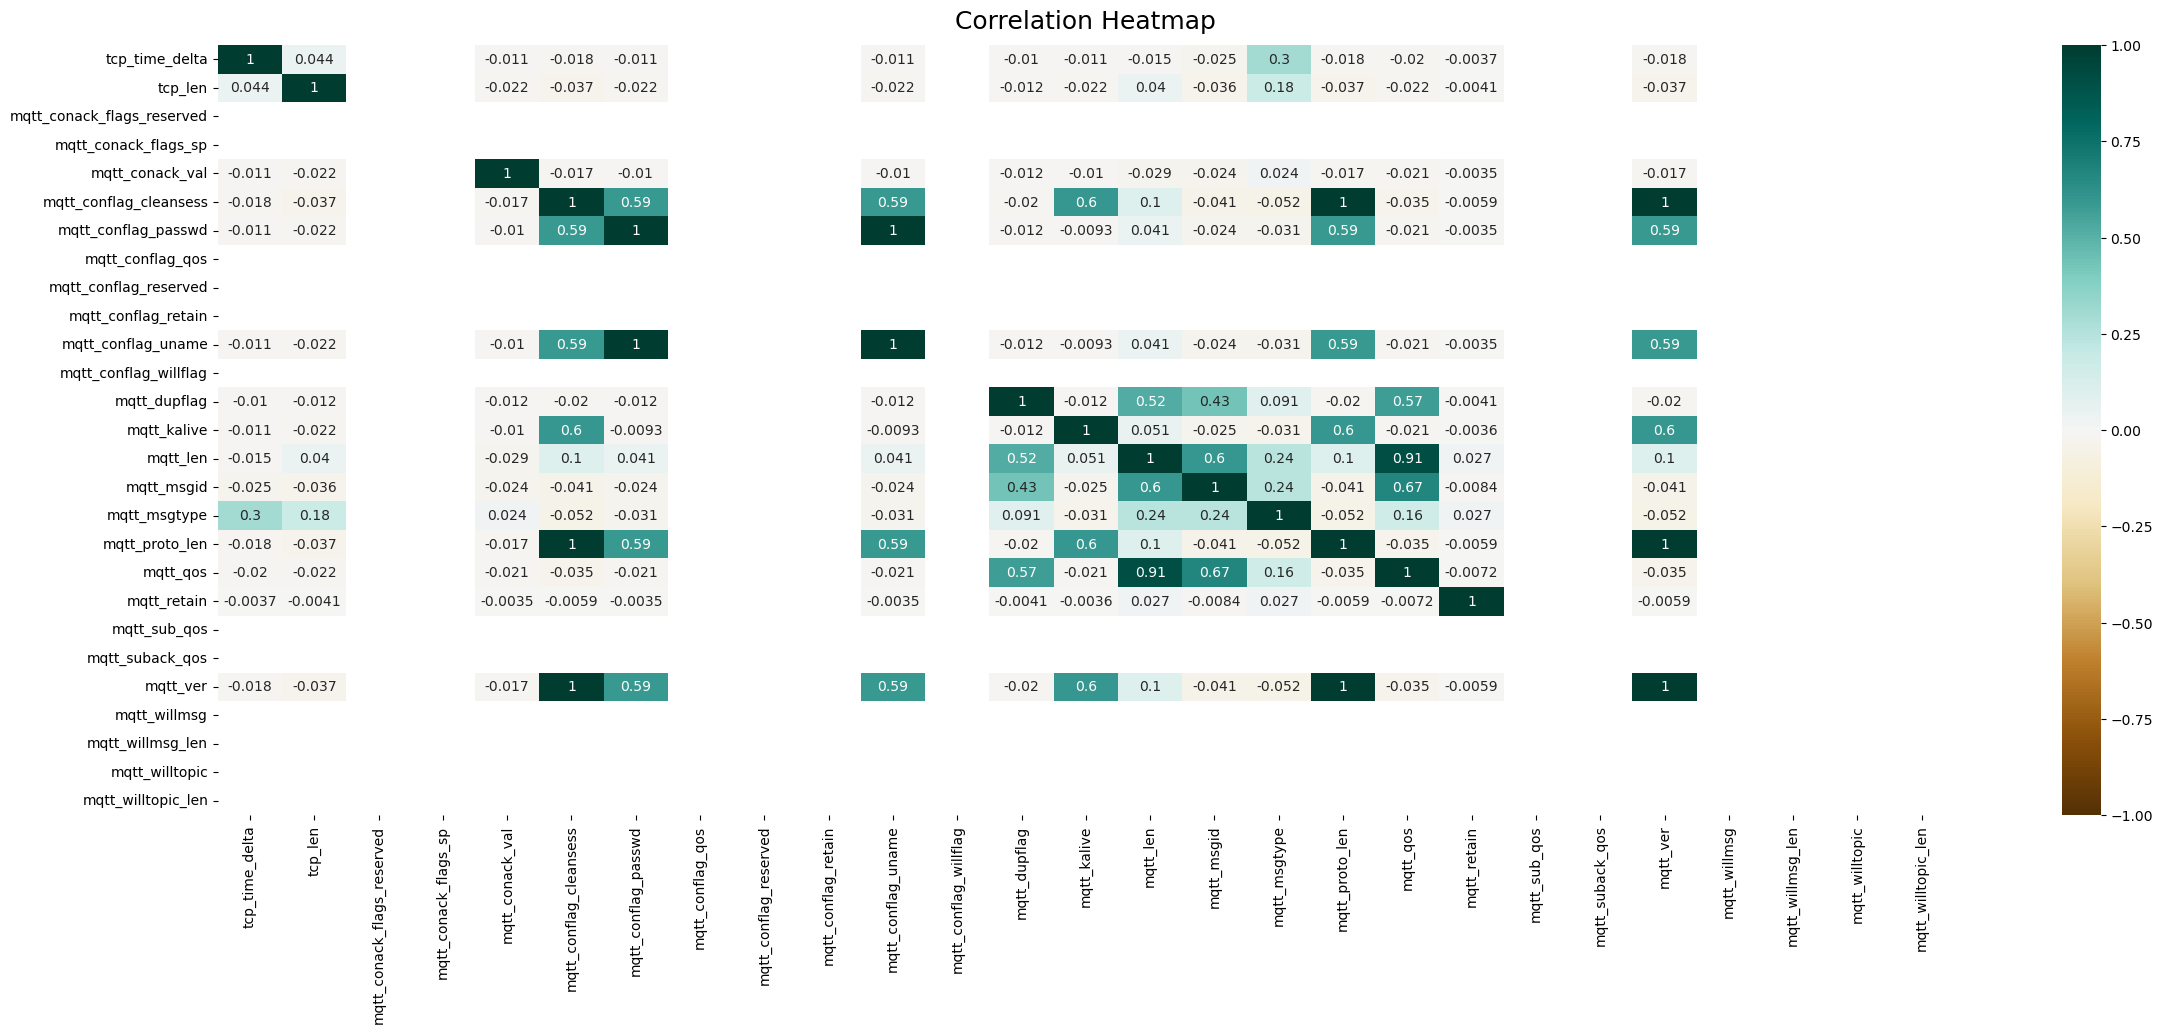

In [48]:

plt.figure(figsize=(28, 10))
heatmap = sns.heatmap(DF[continuous_cols].toPandas().corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

22/11/28 05:44:53 WARN org.apache.spark.scheduler.TaskSetManager: Stage 45 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.
22/11/28 05:44:58 WARN org.apache.spark.scheduler.TaskSetManager: Stage 46 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


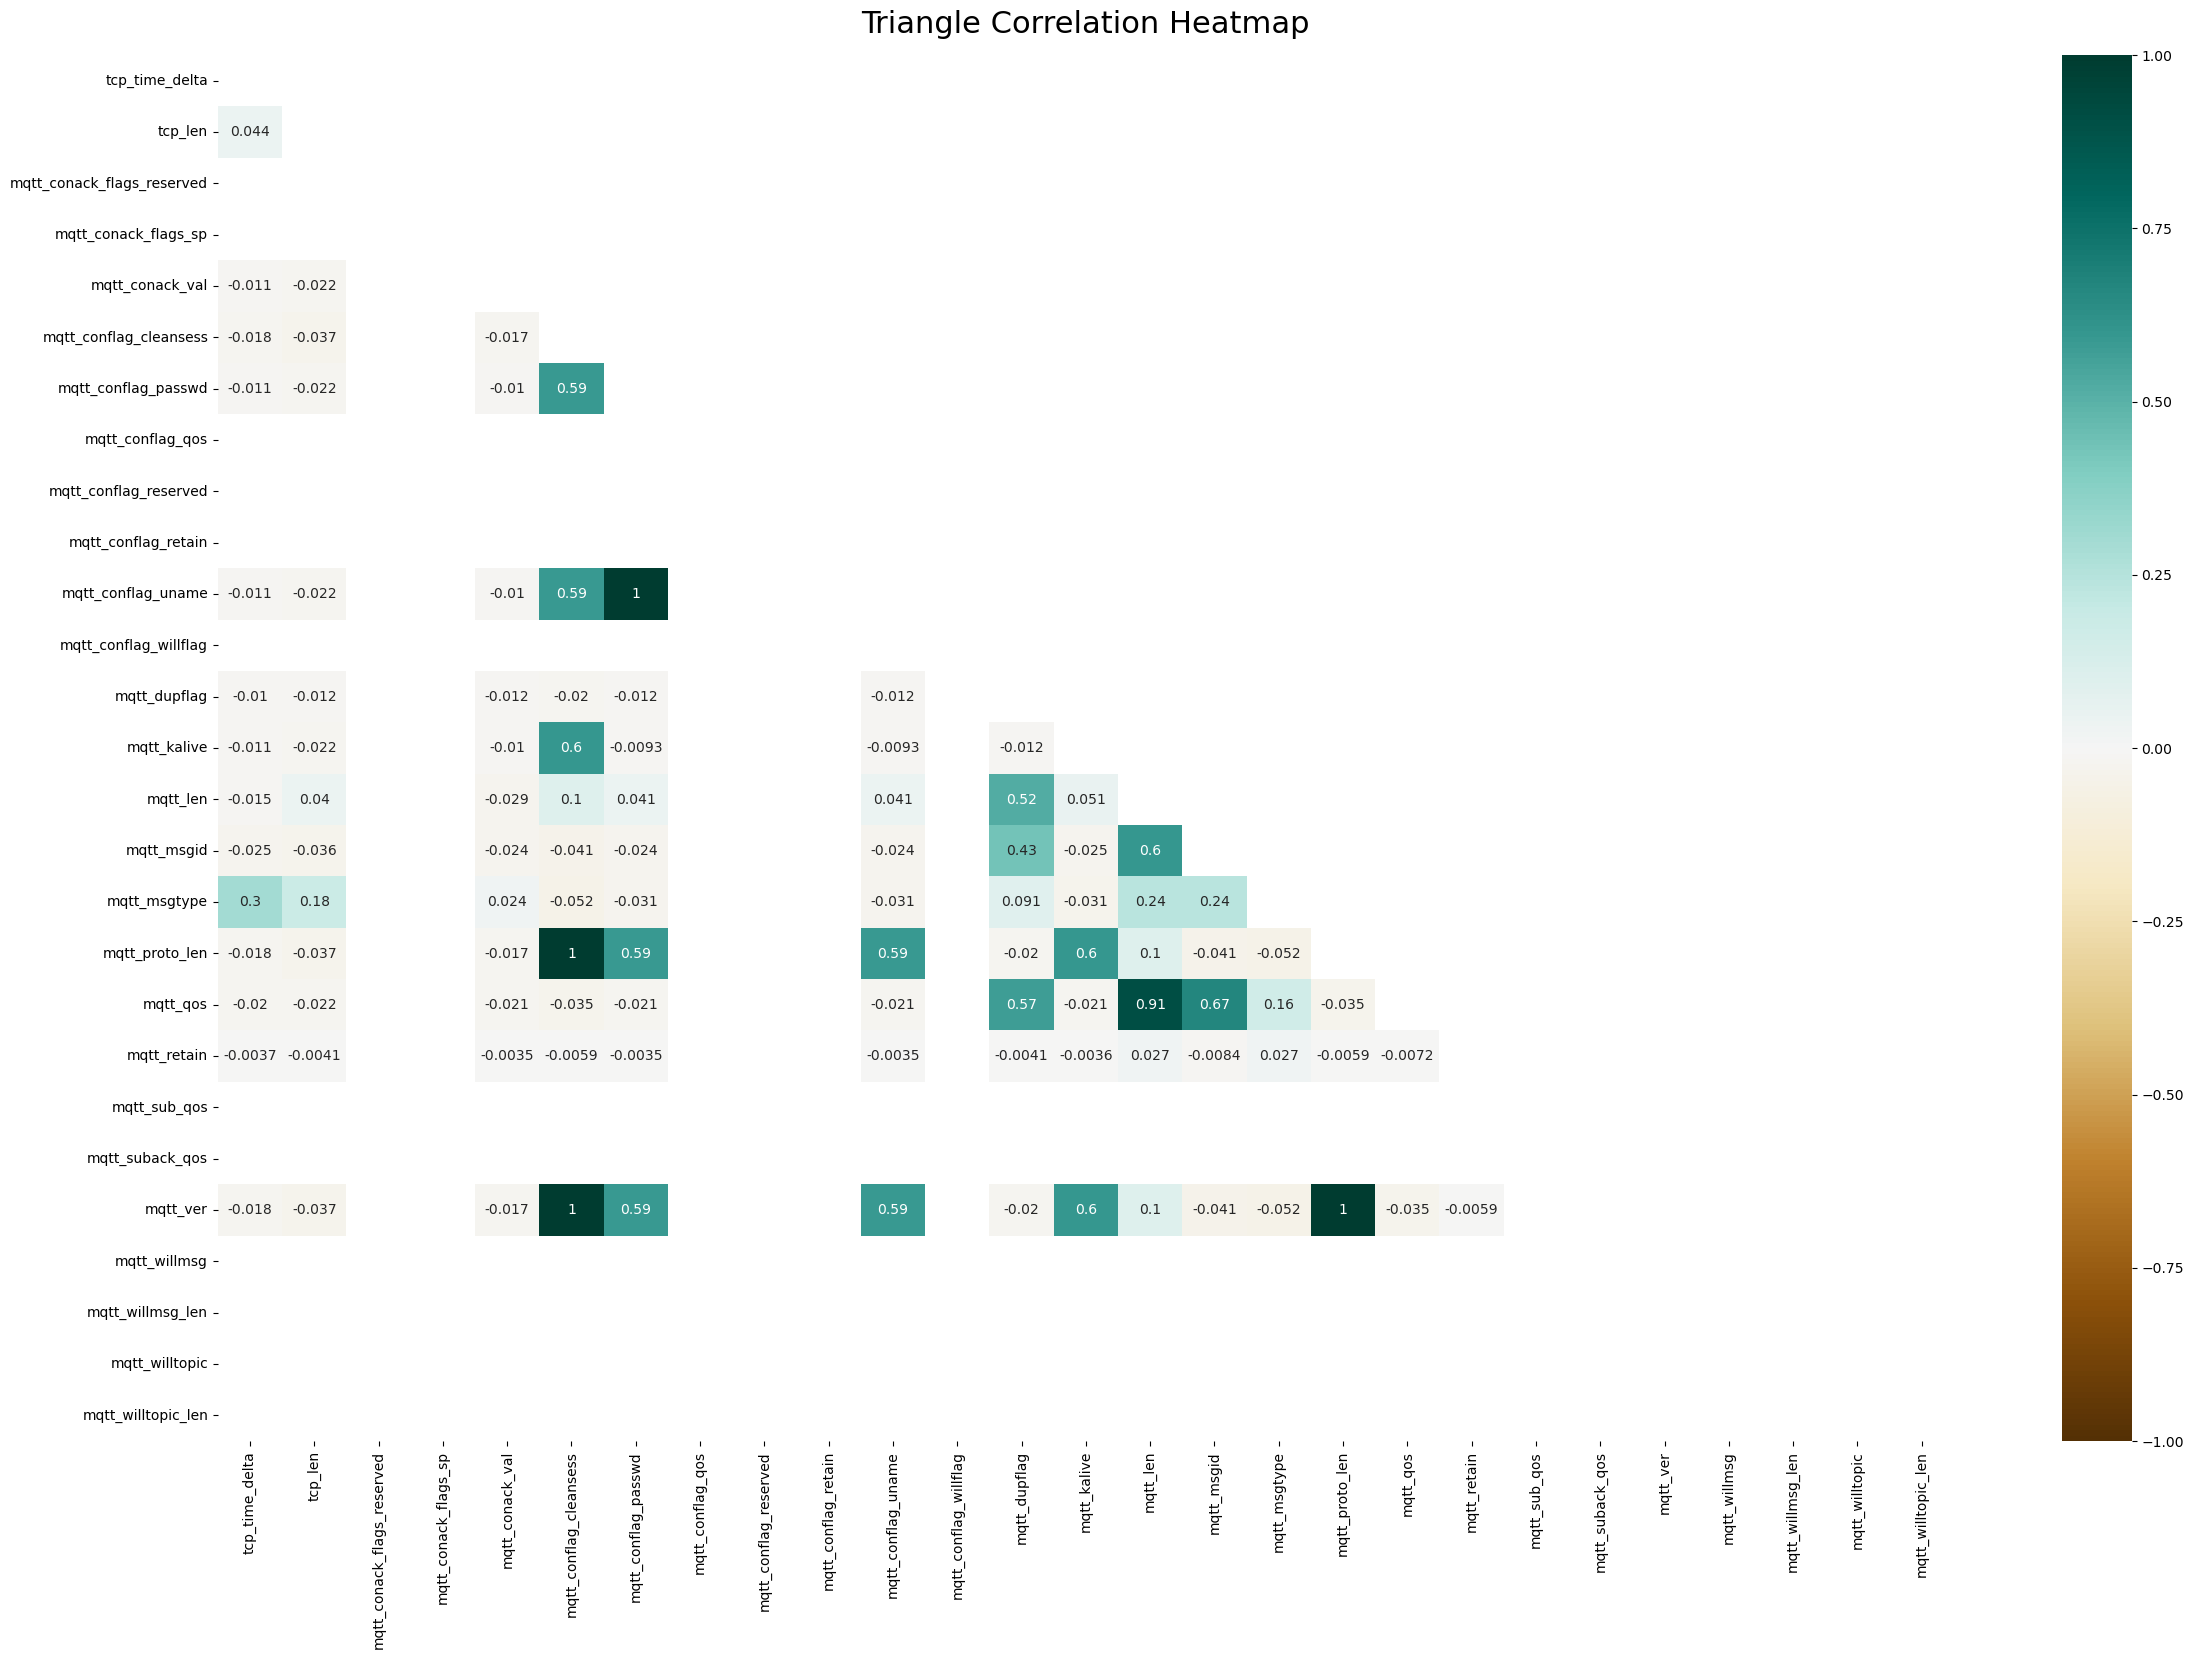

In [49]:
plt.figure(figsize=(28, 18))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(DF[continuous_cols].toPandas().corr(), dtype=np.bool))
heatmap = sns.heatmap(DF[continuous_cols].toPandas().corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':22}, pad=16);

Correlation matrix, is a mirrored along the diagonal, so looking at the triangular matrix will help find the columns better. This image is just to show the triangular correlation matrix.
Later in the code we have used upper triangular matrix to find the columns which we need to drop. Using this we showed any triangular matrix can be used to find columns with high correlation. 

In [50]:
#accessing upper triangular matrix

cor_matrix = DF.toPandas().corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

22/11/28 05:45:13 WARN org.apache.spark.scheduler.TaskSetManager: Stage 47 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


In [51]:
# dropping highly correlated columns

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.89)]
print(); print(to_drop)


['mqtt_conflag_uname', 'mqtt_proto_len', 'mqtt_qos', 'mqtt_ver']


In [52]:
#checking different types of attacks: this information will be helpful while coding ML-model and figuring out the type of attcak
DF.select("target").distinct().collect()

22/11/28 05:45:28 WARN org.apache.spark.scheduler.TaskSetManager: Stage 48 contains a task of very large size (9865 KiB). The maximum recommended task size is 1000 KiB.


[Row(target='slowite'),
 Row(target='bruteforce'),
 Row(target='flood'),
 Row(target='malformed'),
 Row(target='dos'),
 Row(target='legitimate')]